In [1]:
import sys
sys.path.append('/Users/mrgr/Documents/GitHub/FiLeK/')
sys.path.append('/Users/mrgr/Documents/GitHub/KiDS_astronomaly/')
#import visualisation.tsne_plot
import numpy as np
import os
import glob
import importlib
import filek.utils as utils
import filek.gen_cutouts as gen_cutouts
from filek import cutclass
#import filek.models as models
import filek.settings as settings
from astropy.io import fits
import matplotlib.pyplot as plt
import filek.make_rgb as make_rgb
from filek.preprocessing import scaling_clipping
import pandas as pd

from astronomaly.anomaly_detection.human_loop_learning import NeighbourScore, ScoreConverter

%matplotlib inline

2023-05-02 15:43:54.234128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
if False:
    import shutil

    dir1 = '/Users/mrgr/lensto_download' # Replace with the path to the first directory
    dir2 = '/Users/mrgr/to_download'  # Replace with the path to the second directory

    for band in ['r_band', 'g_band', 'i_band']:
        band_dir1 = os.path.join(dir1, band)
        band_dir2 = os.path.join(dir2, band)
        for subdir in os.listdir(band_dir1):
            src_dir = os.path.join(band_dir1, subdir)
            dst_dir = os.path.join(band_dir2, subdir)
            if os.path.isdir(dst_dir):
                # If the destination directory already exists, add the files to it
                for filename in os.listdir(src_dir):
                    src_file = os.path.join(src_dir, filename)
                    dst_file = os.path.join(dst_dir, filename)
                    shutil.move(src_file, dst_file)
            else:
                # If the destination directory doesn't exist, move the entire source directory
                shutil.move(src_dir, dst_dir)


load labels

In [5]:
def drop_unnamed(df):
    """Drops any columns named 'Unnamed: n' with n any number."""
    return df.loc[:, ~df.columns.str.startswith('Unnamed:')]


df_list = pd.read_csv(os.path.join(settings.path_to_save_imgs, 'mock','df_list.csv')).dropna()
print('# Lenses {}, # not lenses {}, # tot {}'.format(len(df_list[df_list['LABEL']==1]),len(df_list[df_list['LABEL']==0]) , len(df_list)))
df_lens = pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock', 'I_have_lens_catalog.csv')).dropna()
print('# Lenses {}, # not lenses {}, # tot {}'.format(len(df_lens[df_lens['LABEL']==1]),len(df_lens[df_lens['LABEL']==0]) , len(df_lens)))

df_tot = pd.concat([df_list, df_lens], ignore_index=True).reset_index(drop=True).drop_duplicates()

df_tot = drop_unnamed(df_tot)
df_tot.rename(columns={"LABEL": "LABEL_TE"}, inplace=True)

df_tot = df_tot[df_tot['LABEL_TE'].isin([0, 1])].drop_duplicates(subset='KIDS_ID').reset_index(drop=True)
print('# Lenses {}, # not lenses {}, # tot {}'.format(len(df_tot[df_tot['LABEL_TE']==1]),len(df_tot[df_tot['LABEL_TE']==0]) , len(df_tot)))

#shuffle it
df_tot = df_tot.sample(frac=1).reset_index(drop=True)
df_tot.to_csv(os.path.join(settings.path_to_save_imgs,'mock','df_tot.csv'),  index=False)

#TODO: balance in test and train the amount of lenses
#train_df= pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock','train_df.csv'))
#test_df= pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock','test_df.csv'))


# Lenses 4, # not lenses 2408, # tot 2578
# Lenses 169, # not lenses 0, # tot 169
# Lenses 172, # not lenses 2342, # tot 2514


In [6]:
len(df_tot)

2514

In [7]:
if False:
    from sklearn.model_selection import train_test_split

    # Split your dataframe into training and test sets
    train_df, test_df = train_test_split(df_tot, test_size=0.2, random_state=42)
    train_df.to_csv(os.path.join(settings.path_to_save_imgs,'mock','train_df.csv'),  index=False)
    test_df.to_csv(os.path.join(settings.path_to_save_imgs,'mock','test_df.csv'), index=False)

In [8]:
if False:
    df_list_obj= pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock','test_df.csv')).drop_duplicates(subset='KIDS_ID').reset_index(drop=True)
    df_list_obj['FOLDER'] = str(os.path.join(settings.path_to_save_imgs,'mock'))
    for idx in range(len(df_list_obj)):
        try:
            utils.from_fits_to_array(df_list_obj.loc[idx, 'FOLDER'],
                                        df_list_obj.loc[idx,'KIDS_ID'] ,df_list_obj.loc[idx, 'KIDS_TILE'],  
                                        channels=['r', 'i','g'])
        except:
            print(idx)

In [11]:
def recall(ml_score, bin=1, column='LABEL_TE', sort_by='score'):

    #ml_score[column] = ml_score['Unnamed: 0'].map(df_tot.set_index('KIDS_ID')[column]).replace(1, 5)
    df_sorted = ml_score.sort_values(sort_by, ascending=False)
    num_elements = np.arange(1, len(df_sorted)+1, bin)
    recalls = []
    for i in num_elements:
        true_labels = df_sorted.iloc[:i][column]
        remaining_lablels = df_sorted.iloc[i:][column]
        TP = len(np.where(true_labels==5)[0])
        FN = len(np.where(remaining_lablels==5)[0])
        recall = TP / (TP+FN)
        
        recalls.append(recall)
    return num_elements, recalls


def tp_norm(ml_score, bin=1, column='LABEL_TE'):

    df_sorted = ml_score.sort_values('score', ascending=False)
    num_elements = np.arange(1, len(df_sorted)+1, bin)
    recalls = []
    for i in num_elements:
        true_labels = df_sorted.iloc[:i][column]
        TP = len(np.where(true_labels==5)[0])
        recall = TP / len(true_labels)
        recalls.append(recall)
    return num_elements, recalls

In [52]:
import errno
import re

def give_labels(df_tot, output_dir, num_to_label=200):

    features = pd.read_parquet(os.path.join(output_dir, 'FeatureScaler_output.parquet'))

    filename = 'ScoreConverter_output.parquet'
   # path = os.path.join(output_dir,filename)

    #TODO add which one to load
    file_list = glob.glob( os.path.join(output_dir, filename.split('.')[0]+'*'))

    # Get the base filename and extension
    basename, ext = os.path.splitext(filename)

    if len(file_list)>1:# Define the naming pattern for the files you're looking for
        pattern = r"^ScoreConverter_output_(\d+)\.parquet$"

        # Get a list of all files in the directory that match the pattern
        files = [f for f in os.listdir(output_dir) if re.match(pattern, f)]

        # Sort the files by their suffixes
        files_sorted = sorted(files, key=lambda f: int(re.match(pattern, f).group(1)))

        # Return the last file (with the highest suffix)
        if files_sorted:
            filename = files_sorted[-1]
        else:
            filename = None

        '''
        #ns was run already it means i need to save it with a number
        counter = 0
        while os.path.exists(os.path.join(output_dir, filename)):
            filename= f"{basename}_{counter}{ext}"
            counter += num_to_label
        '''
        print(f'loaded {filename}')


    elif os.path.exists(file_list[0]):
        #first time
        print(f'loaded {filename}')
    else:
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)

    anomalies = pd.read_parquet(os.path.join(output_dir,filename))

    if 'human_label' not in anomalies.columns:
        anomalies['human_label'] = [-1]*len(anomalies)

    anomalies= anomalies.sort_values('score', ascending=False)
    mask = anomalies['human_label'] == -1
    rows_to_update = anomalies.loc[mask].iloc[:num_to_label].index
    try:
        df_tot = df_tot.set_index('KIDS_ID')
    except KeyError:
        pass
    #update both files, anomalies and ml_score
    anomalies.loc[rows_to_update, 'human_label'] = df_tot.loc[rows_to_update, 'LABEL_TE'].replace(1, 5)
    
    if os.path.exists(os.path.join(output_dir,'ml_scores.csv')) and len(mask)!=len(anomalies):
        #if it not the first time labeling 
        ml_df = pd.read_csv(os.path.join(output_dir,'ml_scores.csv'))
        try:
            ml_df = ml_df.set_index(['Unnamed: 0'])
        except KeyError:
            pass
    else:
        print('creating ml_scores.csv file ')
        #create the file
        IF_conv = pd.read_parquet(os.path.join(output_dir, 'ScoreConverter_output.parquet'))
        ml_df = IF_conv.assign(human_label=[-1]*len(IF_conv.score))

    ml_df.loc[rows_to_update, 'human_label'] = df_tot.loc[rows_to_update, 'LABEL_TE'].replace(1, 5)
    ml_df.to_csv(os.path.join(output_dir,'ml_scores.csv'))

    ns = NeighbourScore(alpha=0.1, force_rerun=True, output_dir = output_dir)
    features_with_labels = ns.combine_data_frames(features, anomalies)
    try:
        final_score = ns.run(features_with_labels.drop(['final_score'],axis=1))
    except KeyError:
         final_score = ns.run(features_with_labels)

    anomalies['final_score'] = final_score.trained_score
    num_lab = len(anomalies) - len(anomalies.loc[anomalies['human_label'] == -1])
    print(f'saved as ScoreConverter_{num_lab}_output.parquet')
    anomalies.to_parquet(os.path.join(output_dir, f'ScoreConverter_output_{num_lab}.parquet'))



In [13]:
def sorted_scoreconv(output_dir):
    pattern = r"^ScoreConverter_output_(\d+)\.parquet$"

    # Get a list of all files in the directory that match the pattern
    files = [f for f in os.listdir(output_dir) if re.match(pattern, f)]

    # Sort the files by their suffixes
    files_sorted = sorted(files, key=lambda f: int(re.match(pattern, f).group(1)))

    return files_sorted

def read_mlscore(output_dir):
    return pd.read_csv(os.path.join(output_dir, 'ml_scores.csv'))


In [14]:
def plot_recall_all_maxlabeled(list_subdir, num_labeled_=None):

    fig_dir = os.path.join(data_dir, 'figures')

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    img_prep_list = []


    #plot no active learning for comparison
    #the starting point is the same for all of them
    anomalies = pd.read_parquet(os.path.join(list_subdir[0],'ScoreConverter_output.parquet'))
    anomalies.loc[:, 'LABEL_TE'] = df_list_obj.loc[:, 'LABEL_TE'].replace(1, 5) 
    num_elements_tmp_sc, recalls_tmp_sc = recall(anomalies, sort_by='score')
    plt.plot(num_elements_tmp_sc, recalls_tmp_sc,  label='No active learning' )
  
    for subdir in list_subdir:
        img_prep = subdir.split('img_prep_')[1].split('_dim_')[0]
        img_prep_list.append(img_prep)

        if num_labeled_ is None:
           
            parq_filename = sorted_scoreconv(subdir)[-1]
            num_labeled = parq_filename.split('output_')[1].split('.parquet')[0] 
        else:
            #print([item for item in subdir if str(num_labeled_) in item])
            num_labeled  = str(num_labeled_)
            matches = [item for item in glob.glob(os.path.join(subdir,'*')) if num_labeled in item]
            if len(matches) > 0:
                parq_filename = matches[0]
            else:
                print(f"No files found with num_labeled = {num_labeled}")
                return

        anomalies = pd.read_parquet(os.path.join(subdir,parq_filename))
        anomalies.loc[:, 'LABEL_TE'] = df_list_obj.loc[:, 'LABEL_TE'].replace(1, 5) 
        
        label_fin = img_prep+f', {num_labeled} labeled'
        num_elements_tmp_fin, recalls_tmp_fin = recall(anomalies, sort_by='final_score')
        plt.plot(num_elements_tmp_fin, recalls_tmp_fin,label=label_fin) 

    plt.legend(loc='lower right')
    plt.title('Different preprocessing')
    plt.xlabel('Index in ranked list')
    plt.ylabel('Recall')

    plt.savefig(os.path.join(fig_dir,f'ALL_Recall_img_prep_{img_prep}_lab_{num_labeled}.png'))
    plt.show()



In [15]:
def plot_recall(subdir):
    
    fig_dir = os.path.join(subdir, 'figures')

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    parq_filename_list = []
    img_prep = subdir.split('img_prep_')[1].split('_dim_')[0]

    num_labeled_list = []
    for parq_filename in sorted_scoreconv(subdir):
        parq_filename_list.append(parq_filename)
        num_labeled = parq_filename.split('output_')[1].split('.parquet')[0] 
        num_labeled_list.append(num_labeled)
        anomalies = pd.read_parquet(os.path.join(subdir,parq_filename))
        anomalies.loc[:, 'LABEL_TE'] = df_list_obj.loc[:, 'LABEL_TE'].replace(1, 5) 
        #label_sc = f'{str(int(num_labeled)-200)} labeled'
        label_fin = f'{num_labeled} labeled'
        if int(num_labeled)==200:
            label_sc = 'No active learning' 
            num_elements_tmp_sc, recalls_tmp_sc = recall(anomalies, sort_by='score')
            plt.plot(num_elements_tmp_sc, recalls_tmp_sc,  label=label_sc)
        
        num_elements_tmp_fin, recalls_tmp_fin = recall(anomalies, sort_by='final_score')
        plt.plot(num_elements_tmp_fin, recalls_tmp_fin,label=label_fin) 

    plt.legend(loc='lower right')
    plt.title(f'img_prep : {img_prep}' )
    plt.xlabel('Index in ranked list')
    plt.ylabel('Recall')

    plt.savefig(os.path.join(fig_dir,f'Recall_img_prep_{img_prep}_lab_{"_".join(num_labeled_list)}.png'))
    plt.show()


In [271]:
# Set custom parameters using rcParams
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['legend.fontsize'] = 14


In [42]:
data_dir = os.path.join('/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/')
# Where output should be stored
output_dirs = sorted(glob.glob(os.path.join(data_dir, 'astronomaly_output','*')))
output_dirs = [item for item in output_dirs if os.path.isdir(item)]
df_list_obj= pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock','df_tot.csv')).drop_duplicates(subset='KIDS_ID').reset_index(drop=True)[:-1]
df_list_obj = df_list_obj.set_index('KIDS_ID')

len(df_list_obj[df_list_obj[ 'LABEL_TE'] ==1]), len(df_list_obj[df_list_obj[ 'LABEL_TE'] ==0])

(172, 2341)

In [43]:
outdir_name =  [item.split('/')[-1] for item in output_dirs ]

In [44]:
outdir_name[0]

['kids_model_cnn_weights_zoobot_img_prep_clipping_rband_dim_reduction_pca',
 'kids_model_cnn_weights_zoobot_img_prep_grey_clipping_dim_reduction_pca',
 'kids_model_cnn_weights_zoobot_img_prep_grey_dim_reduction_pca',
 'kids_model_cnn_weights_zoobot_img_prep_rband_dim_reduction_pca']

In [55]:
give_labels(df_list_obj, output_dirs[1], num_to_label=200)

loaded ScoreConverter_output.parquet
creating ml_scores.csv file 
/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/astronomaly_output/kids_model_cnn_weights_zoobot_img_prep_grey_dim_reduction_pca/astronomaly.log
Now switching to new log file:
/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/astronomaly_output/kids_model_cnn_weights_zoobot_img_prep_grey_clipping_dim_reduction_pca/astronomaly.log
Running NeighbourScore ...
Done! Time taken: 3.074652910232544 s
saved as ScoreConverter_200_output.parquet


In [32]:
for dir in output_dirs: 
    give_labels(df_list_obj, dir, num_to_label=200)

loaded ScoreConverter_output_200.parquet
Running NeighbourScore ...
Done! Time taken: 6.425516128540039 s
saved as ScoreConverter_400_output.parquet
loaded ScoreConverter_output_600.parquet
/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/astronomaly_output/kids_model_cnn_weights_zoobot_img_prep_clipping_rband_dim_reduction_pca/astronomaly.log
Now switching to new log file:
/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/astronomaly_output/kids_model_cnn_weights_zoobot_img_prep_grey_dim_reduction_pca/astronomaly.log
Running NeighbourScore ...
Done! Time taken: 21.287405729293823 s
saved as ScoreConverter_800_output.parquet
loaded ScoreConverter_output_600.parquet
/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/astronomaly_output/kids_model_cnn_weights_zoobot_img_prep_grey_dim_reduction_pca/astronomaly.log
Now switching to new log file:
/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cu

In [27]:
IF_conv = pd.read_parquet(os.path.join(output_dirs[0], 'ScoreConverter_output_200.parquet'))
ml_df = IF_conv.assign(human_label=[-1]*len(IF_conv.score)).sort_values('score', ascending=False)
mask = IF_conv['human_label'] == -1
rows_to_update = IF_conv.loc[mask].iloc[:100].index

600


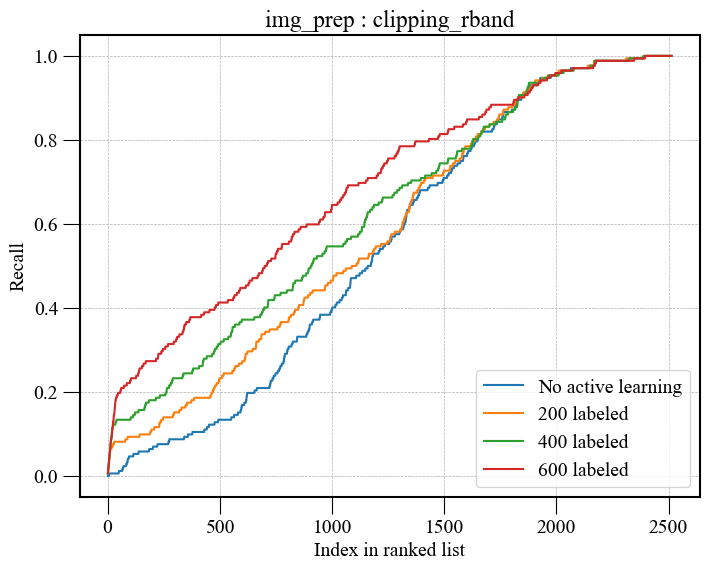

600


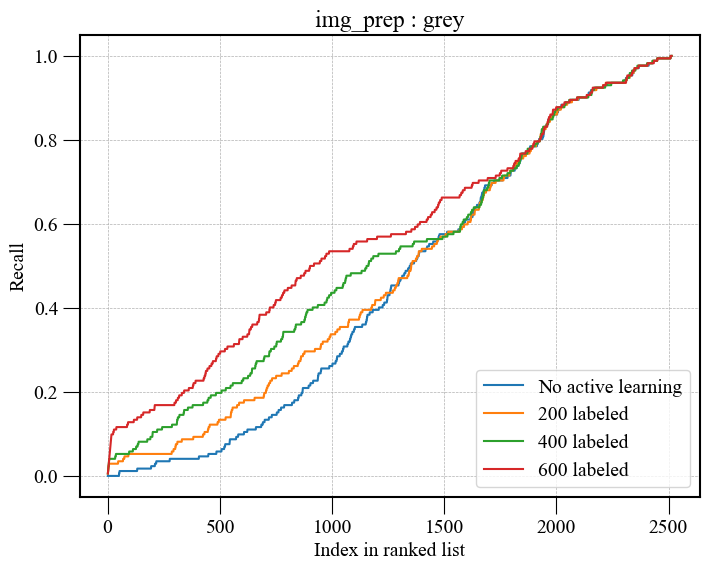

600


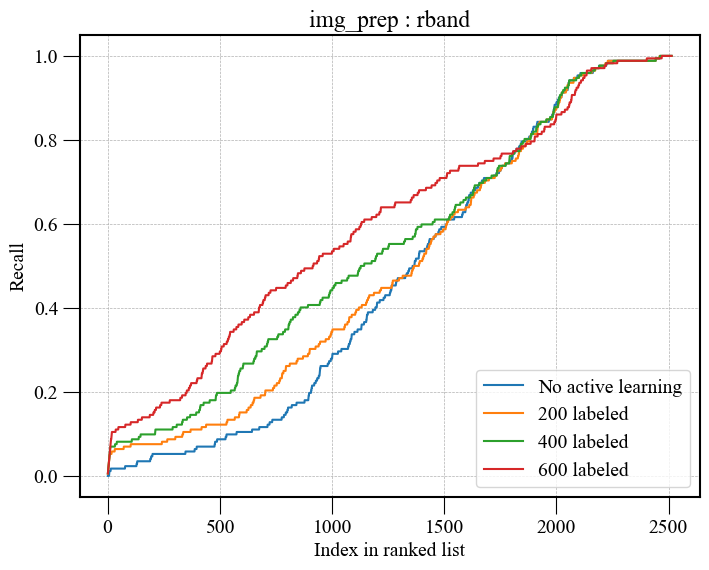

600


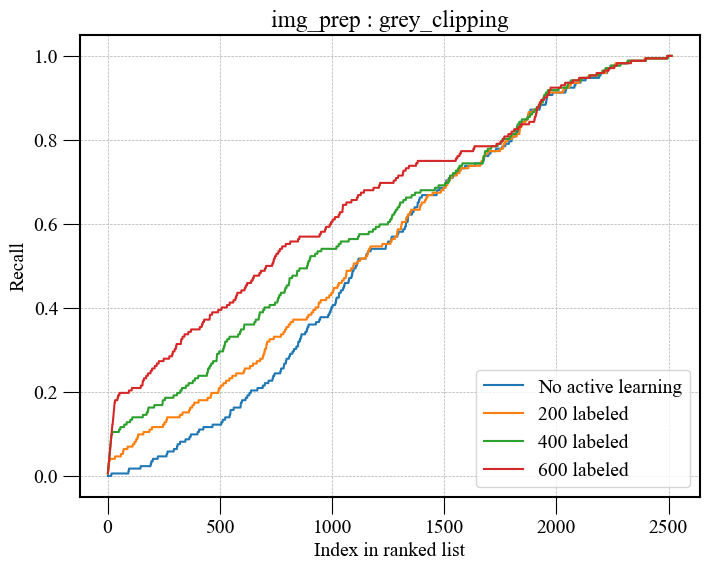

In [357]:
output_dirs = glob.glob(os.path.join(data_dir, 'astronomaly_output','*'))
#check that i have only folders
output_dirs = [item for item in output_dirs if os.path.isdir(item)]
for subdir in output_dirs:
    plot_recall(subdir)

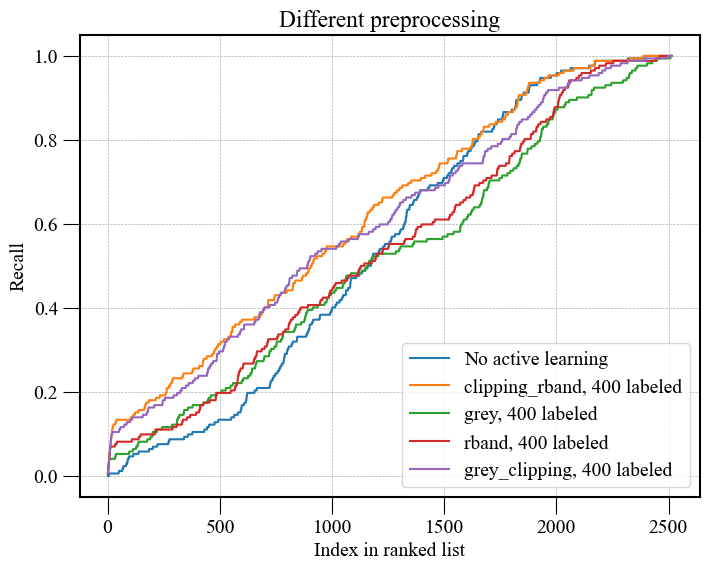

In [384]:
plot_recall_all_maxlabeled(output_dirs,num_labeled_=400 )

In [57]:
rgb = np.load('/Users/mrgr/Documents/GitHub/KiDS_astronomaly/rgb.npy')

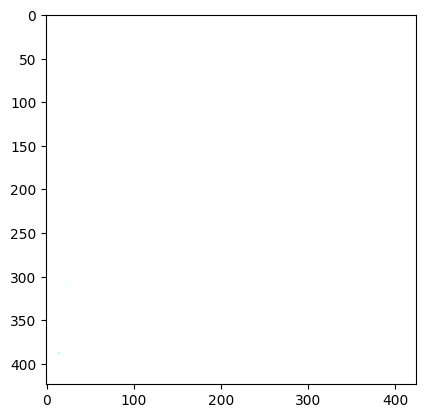

In [59]:
plt.imshow(rgb)